**Table of contents**<a id='toc0_'></a>    
- [Fitting the ZnPc XRR Data](#toc1_)    
  - [Fit 250 eV Data](#toc1_1_)    
    - [Load the 250 eV data](#toc1_1_1_)    
    - [Masking 250 eV](#toc1_1_2_)    
    - [Construct the slab structure for the data](#toc1_1_3_)    
    - [Construct the Objective Function](#toc1_1_4_)    
      - [Constraining the parameters](#toc1_1_4_1_)    
    - [Fitting the data](#toc1_1_5_)    
  - [Fit 283.7 eV Data](#toc1_2_)    
    - [Load the 283.7 eV data](#toc1_2_1_)    
      - [Various Masking Attempts](#toc1_2_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
from sys import path as syspath
from pathlib import Path

syspath.append(str(Path().home() / "pyref" / "src"))

import pyref as rf
import seaborn as sns
import matplotlib.pyplot as plt

# <a id='toc1_'></a>[Fitting the ZnPc XRR Data](#toc0_)
**Harlan Heilman**
---
## <a id='toc1_1_'></a>[Fit 250 eV Data](#toc0_)

The steps to fit the ZnPc XRR data are as follows:
1. Load the 250 eV data
    1. Convert the csv file to a pandas dataframe
    2. Plot the data and see if it looks reasonable - If not, mask the data
    3. Convert the data to a ReflectDataSet
2. Construct the slab structure for the data
    1. Vacuum | ZnPc | Amorphous Carbon | SiO2 | Si
3. Construct the Objective Function
    1. Create models for sp polarization
    2. Create objective functions for 250 eV
    3. Add thick - rough constraints to the prior for each layer
4. Fit the data

### <a id='toc1_1_1_'></a>[Load the 250 eV data](#toc0_)

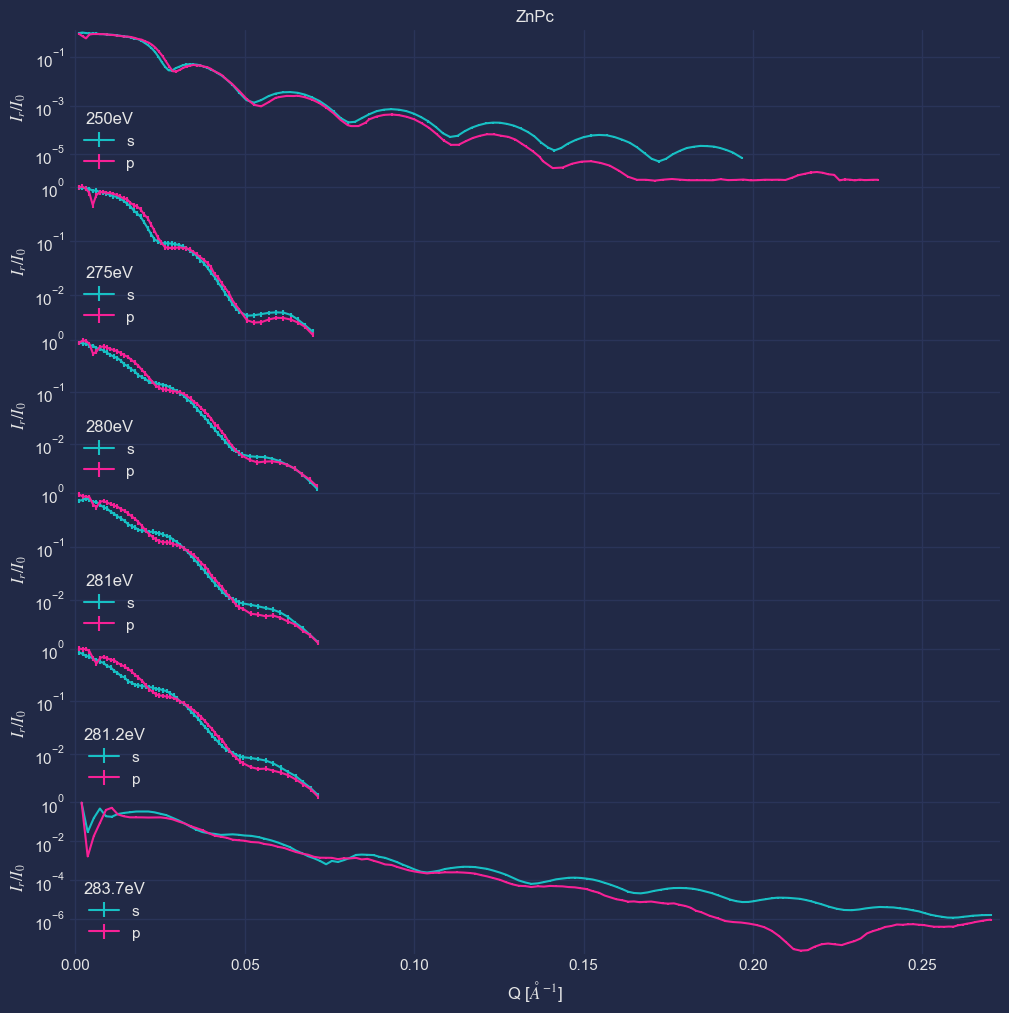

In [12]:
db = rf.db()

znpc_oc = db.get_oc("C32H16N8Zn")
znpc_mono = {
    "250": {
        "s": db.get_refl("zrt_250.0_100.csv", "ZnPc"),
        "p": db.get_refl("zrt_250.0_190.csv", "ZnPc"),
        },
    "275": {
        "s": db.get_refl("275.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("275.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "280": {
        "s": db.get_refl("280.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("280.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "281": {
        "s": db.get_refl("281.0_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("281.0_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "281.2": {
        "s": db.get_refl("281.2_100.0_refl.parquet.gzip", "ZnPc"),
        "p": db.get_refl("281.2_190.0_refl.parquet.gzip", "ZnPc"),
        },
    "283.7": {
        "s": db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc"),
        "p": db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc"),
        },
}
fig, ax = plt.subplots(nrows = len(znpc_mono.keys()), figsize = (12, 12),sharex=True, gridspec_kw={"hspace":0})

for i, (k,v) in enumerate(znpc_mono.items()):
    v["s"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "s", logy = True, color = "C0")
    v["p"].plot(ax = ax[i], x = "Q", y = "Refl", yerr = "Err", label = "p", logy = True, color = "C1")

    if i == 0:
        ax[i].set(
            title = "ZnPc",
            ylabel = r"$I_r / I_0$",
        )
    elif i == len(znpc_mono.keys()) - 1:
        ax[i].set(
            xlabel = r"Q [$\AA^{-1}$]",
            ylabel = r"$I_r / I_0$",
        )
    else:
        ax[i].set(
            ylabel = r"$I_r / I_0$",
        )
    ax[i].legend(
        loc = "lower left",
        title = k + "eV",
    )

### <a id='toc1_1_2_'></a>[Masking 250 eV](#toc0_)

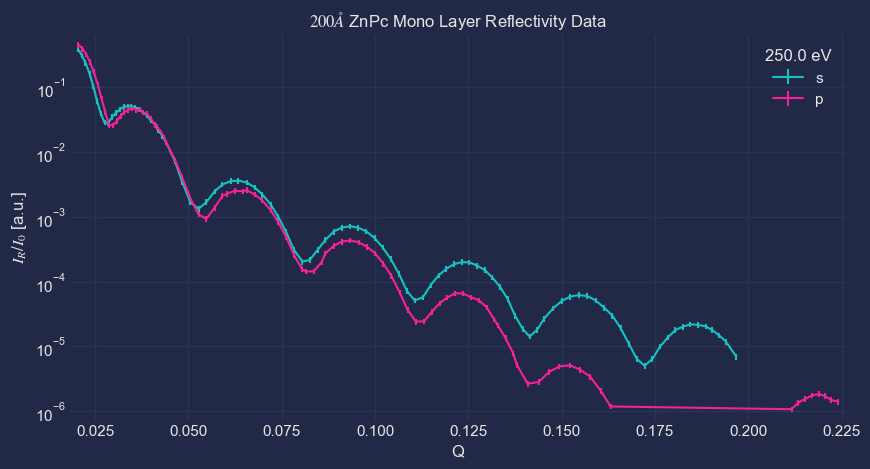

In [21]:
znpc_mono_250_s = rf.smart_mask(znpc_mono["250"]["s"])
znpc_mono_250_p = rf.smart_mask(znpc_mono["250"]["p"], pol = "p")

fig, ax = plt.subplots()
znpc_mono_250_s.plot(ax = ax, x = "Q", y = "Refl", yerr="Err")
znpc_mono_250_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)
ax.legend(title = "250.0 eV", labels = ["s", "p"])

znpc_mono_250 = rf.to_refnx_dataset(znpc_mono_250_s, pol = "sp", second_pol=znpc_mono_250_p)

### <a id='toc1_1_3_'></a>[Construct the slab structure for the data](#toc0_)

I have allready fit this structure several times. So I will just load the structure from a .json file. 

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

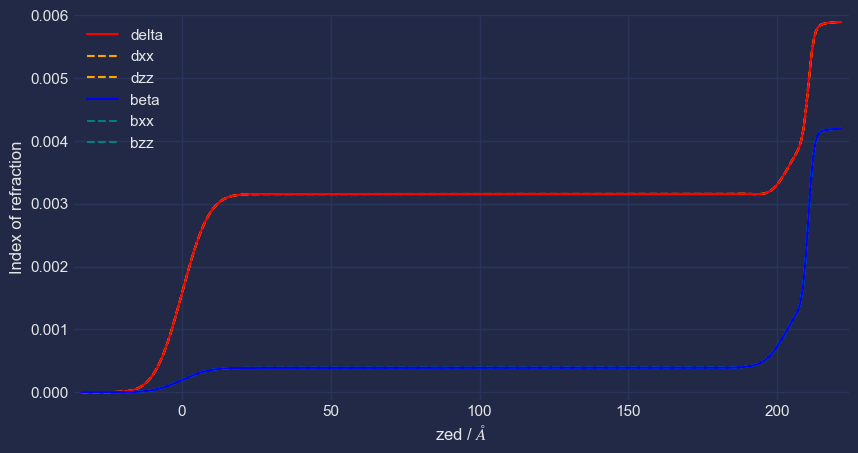

In [22]:
from pypxr.structure import *
from pypxr.reflectivity import *
from refnx.dataset import ReflectDataset
from refnx.analysis import Transform, CurveFitter, Objective
from refnx._lib.emcee.moves.de import *


# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

# generate slabs
en = 250
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si = PXR_MaterialSLD("Si", 2.3, en, name="Si")(znpc_mono_struct_file["Si"]["thickness"],znpc_mono_struct_file["Si"]["roughness"])
sio2 = PXR_MaterialSLD("SiO2", 1.6, en, name="SiO2")(znpc_mono_struct_file["SiO2"]["thickness"],znpc_mono_struct_file["SiO2"]["roughness"])
c_amor = PXR_MaterialSLD("C", 1.6, en, name="C_Amorphous")(znpc_mono_struct_file["C"]["thickness"], znpc_mono_struct_file["C"]["roughness"])
znpc = PXR_MaterialSLD("C32H16N8Zn",1.6, en, name="ZnPc")(znpc_mono_struct_file["C32H16N8Zn"]["thickness"], znpc_mono_struct_file["C32H16N8Zn"]["roughness"])

# generate structure
struct_250 = vac | znpc | c_amor | sio2 | si
struct_250.plot()

### <a id='toc1_1_4_'></a>[Construct the Objective Function](#toc0_)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

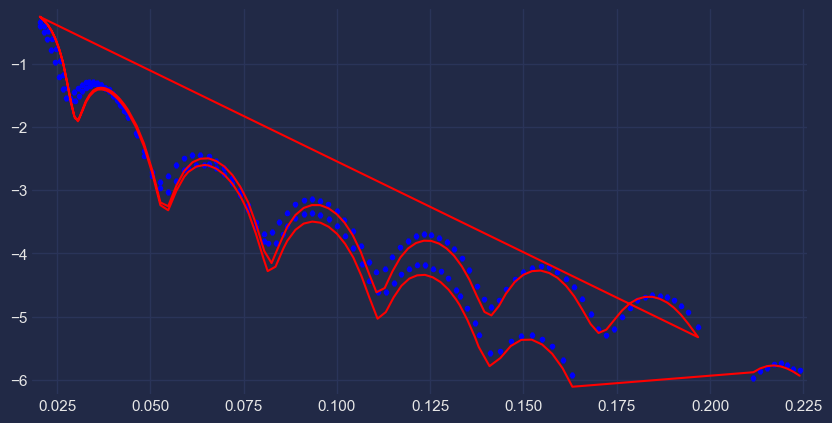

In [23]:
# Building the model from the slab structure

model_250 = PXR_ReflectModel(struct_250, pol = "sp", energy = en, name = "ZnPc Mono Layer 250eV")
model_250.scale.setp(vary = True, bounds = (0.6, 1.2))
model_250.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

# Building the objective function
from pyref.fitting.logp import LogpExtra_rough
obj_250 = Objective(model_250, znpc_mono_250, transform=Transform("logY"))
logp = LogpExtra_rough(obj_250)
obj_250.logp_extra = logp

obj_250.plot()

#### <a id='toc1_1_4_1_'></a>[Constraining the parameters](#toc0_)

The log prior extra ensures that the roughness is allways less than the thickness of the material. Now, we need to ensure that the thickness and roughness are within a series of bounds.

In [24]:
# si slabs
si.thick.setp(vary = False)
si.rough.setp(vary = False)

# sio2 slabs
sio2.thick.setp(vary = True, bounds = (sio2.thick.value*.5, sio2.thick.value*1.5)) # These are well constrained allready by the Bare si fitting
sio2.rough.setp(vary = True, bounds = (sio2.rough.value*.5, sio2.rough.value*1.5))
sio2.sld.density.setp(vary = True, bounds = (sio2.sld.density.value*.5, sio2.sld.density.value*1.5))

# c_amor slabs
c_amor.thick.setp(vary = True, bounds = (c_amor.thick.value*.5, c_amor.thick.value*1.5)) # These are well constrained allready by the Bare si fitting
c_amor.rough.setp(vary = True, bounds = (c_amor.rough.value*.5, c_amor.rough.value*1.5))
c_amor.sld.density.setp(vary = True, bounds = (c_amor.sld.density.value*.5, c_amor.sld.density.value*1.5))

# znpc slabs
znpc.thick.setp(vary = True, bounds = (100, 220)) 
znpc.rough.setp(vary = True, bounds = (0, 20))
znpc.sld.density.setp(vary = True, bounds = (0.5, 2))

### <a id='toc1_1_5_'></a>[Fitting the data](#toc0_)

  0%|          | 0/200 [00:00<?, ?it/s]c:\ProgramData\miniforge3\envs\refl\Lib\site-packages\refnx\_lib\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 200/200 [00:20<00:00,  9.88it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.962413 +/- 0.0695, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=2.68289e-07 +/- 2.63e-07, bounds=[1e-09, 1e-06]>
<Parameter: 'ZnPc_thick'  , value=197.239 +/- 0.991, bounds=[100.0, 220.0]>
<Parameter:     'rho'     , value=1.308 +/- 0.171, bounds=[0.5, 2.0]>
<Parameter: 'ZnPc_rough'  , value=5.77187 +/- 1.37 , bounds=[0.0, 20.0]>
<Parameter:'C_Amorphous_thick', value=6.08446 +/- 0.892, bounds=[3.042335, 9.127005]>
<Parameter:     'rho'     , value=1.65572  +/- 0.3 , bounds=[0.8, 2.4000000000000004]>
<Parameter:'C_Amorphous_rough', value=4.36223 +/- 0.565, bounds=[2.203665, 6.610995]>
<Parameter: 'SiO2_thick'  , value=7.66405 +/- 0.628, bounds=[4.0000015, 12.0000045]>
<Parameter:     'rho'     , value=1.60196 +/- 0.19 , bounds=[0.8, 2.4000000000000004]>
<Parameter: 'SiO2_rough'  , value=5.82181 +/- 0.706, bounds=[3.19154, 9.57462]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

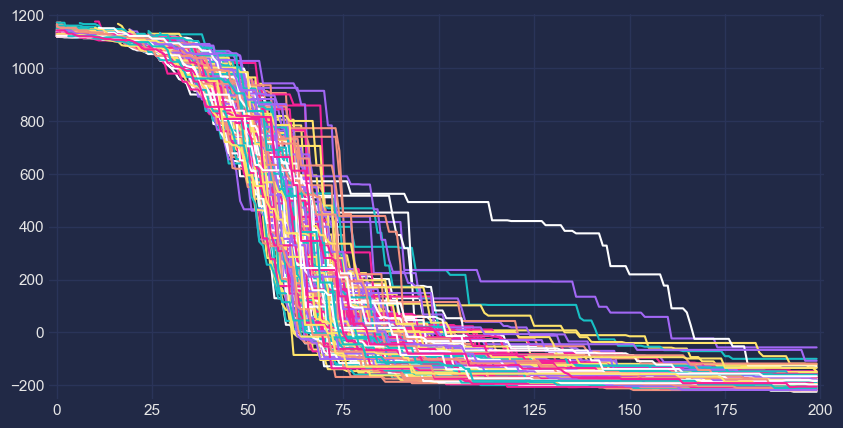

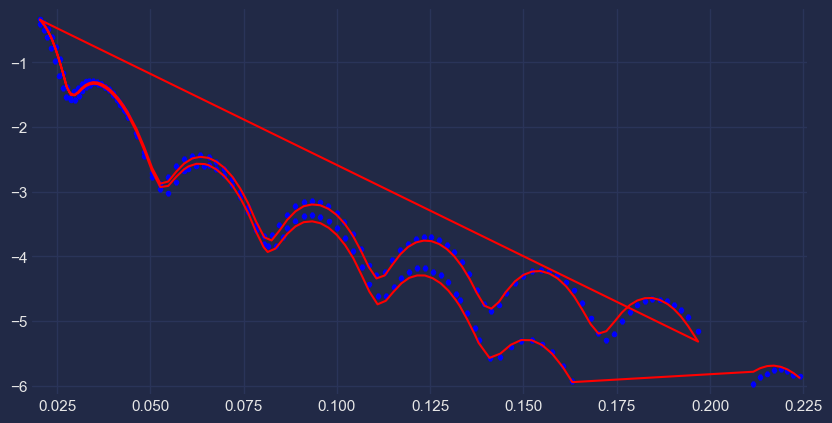

In [25]:
move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7), 0.05)]
nwalkers = 200
nsteps = 200
random_state = 1

fitter = CurveFitter(obj_250, nwalkers=nwalkers, moves = move)
fitter.initialise("jitter")
chain = fitter.sample(int(nwalkers), random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(obj_250.varying_parameters())
obj_250.plot()

In [29]:
# Fitted Structure Parameters

# Si
si_thick = si.thick.value
si_rough = si.rough.value

# SiO2
sio2_thick = sio2.thick.value
sio2_rough = sio2.rough.value
sio2_density = sio2.sld.density.value

# C Amorphous
c_amor_thick = c_amor.thick.value
c_amor_rough = c_amor.rough.value
c_amor_density = c_amor.sld.density.value

# ZnPc
znpc_thick = znpc.thick.value
znpc_rough = znpc.rough.value

## <a id='toc1_2_'></a>[Fit 275](#toc0_)

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

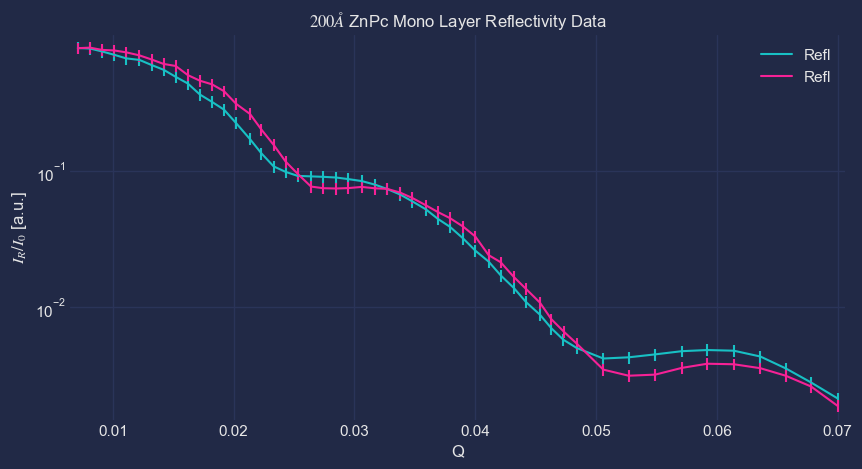

In [49]:
fig, ax = plt.subplots()

znpc_mono_275_s = znpc_mono["275"]["s"].iloc[6:]
znpc_mono_275_p = znpc_mono["275"]["p"].iloc[6:]

znpc_mono_275_s.plot(ax = ax, x = "Q", y = "Refl", yerr="Err")
znpc_mono_275_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")

znpc_mono_275 = rf.to_refnx_dataset(znpc_mono_275_s, pol = "sp", second_pol=znpc_mono_275_p)

ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

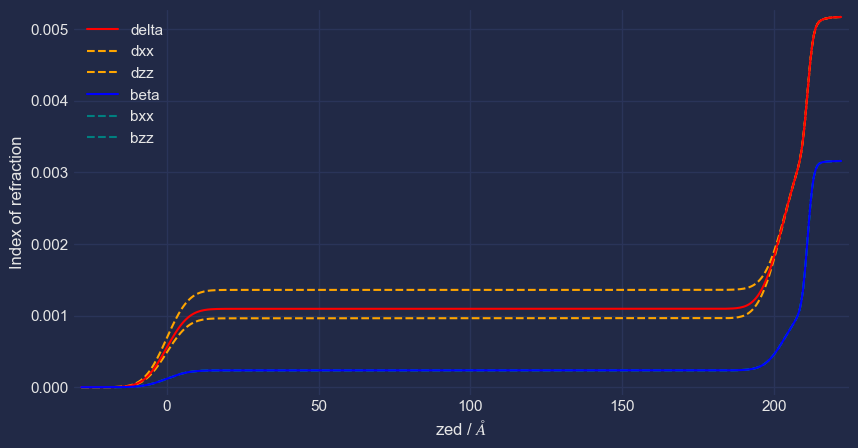

In [55]:
en = 275
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["zz"].n(en), znpc_oc["xx"].n(en)])

znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_275 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_275.plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

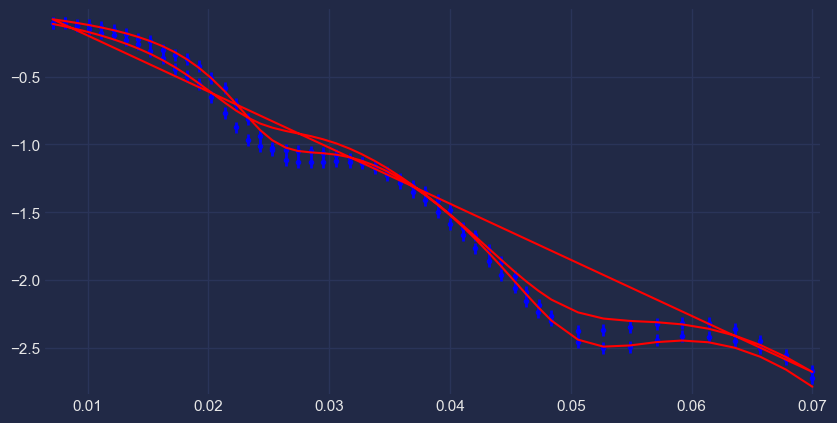

In [56]:
model_275 = PXR_ReflectModel(struct_275, pol = "sp", energy = en, name = "ZnPc Mono Layer 275eV")
model_275.scale.setp(vary = True, bounds = (0.6, 1.2))
model_275.bkg.setp(vary = True, bounds = (1e-9, 1e-6))


obj_275 = Objective(model_275, znpc_mono_275, transform=Transform("logY"))
obj_275.logp_extra = logp

obj_275.plot()

In [59]:
si_1.thick.setp(vary = False)
si_1.rough.setp(vary = False)

sio2_1.thick.setp(vary = None, constraint=sio2_thick)
sio2_1.rough.setp(vary = None, constraint=sio2_rough)
sio2_1.sld.density.setp(vary = None, constraint=sio2_density)

c_amor_1.thick.setp(vary = None, constraint=c_amor_thick)
c_amor_1.rough.setp(vary = None, constraint=c_amor_rough)
c_amor_1.sld.density.setp(vary = None, constraint=c_amor_density)

znpc_1.thick.setp(vary = None, constraint=znpc_thick)
znpc_1.rough.setp(vary = None, constraint=znpc_rough)

znpc_1.sld.beta.setp(vary = True, bounds = (0, .0005))
znpc_1.sld.delta.setp(vary = True, bounds = (0,.002))

znpc_1.sld.xx.setp(vary = True, bounds = (0, .002))
znpc_1.sld.zz.setp(vary = True, bounds = (0, .002))
znpc_1.sld.ixx.setp(vary = None, constraint = znpc_1.sld.beta)
znpc_1.sld.izz.setp(vary = None, constraint = znpc_1.sld.beta)

100%|██████████| 200/200 [01:40<00:00,  1.98it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=1.05309 +/- 0.0411, bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=4.93712e-07 +/- 3.42e-07, bounds=[1e-09, 1e-06]>
<Parameter:  'ZnPc_diso'  , value=0.00109381 +/- 0.000577, bounds=[0.0, 0.002]>
<Parameter:  'ZnPc_biso'  , value=0.000318329 +/- 4.83e-05, bounds=[0.0, 0.0005]>
<Parameter:   'ZnPc_xx'   , value=0.00121805 +/- 0.000127, bounds=[0.0, 0.002]>
<Parameter:   'ZnPc_zz'   , value=0.00145053 +/- 5.93e-05, bounds=[0.0, 0.002]>


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

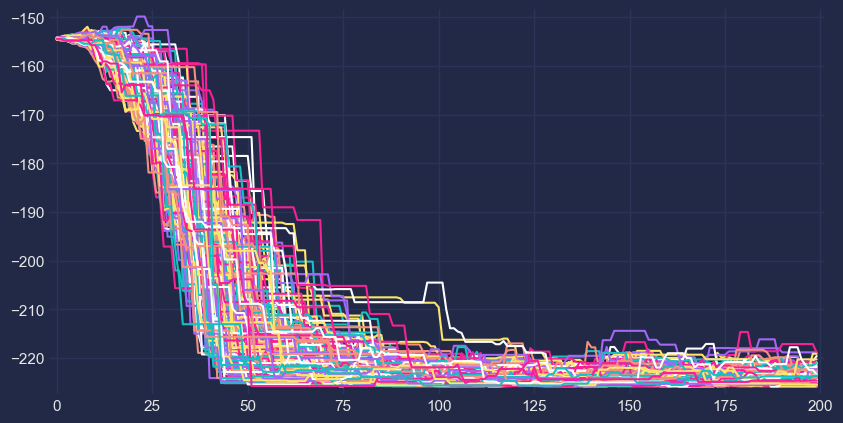

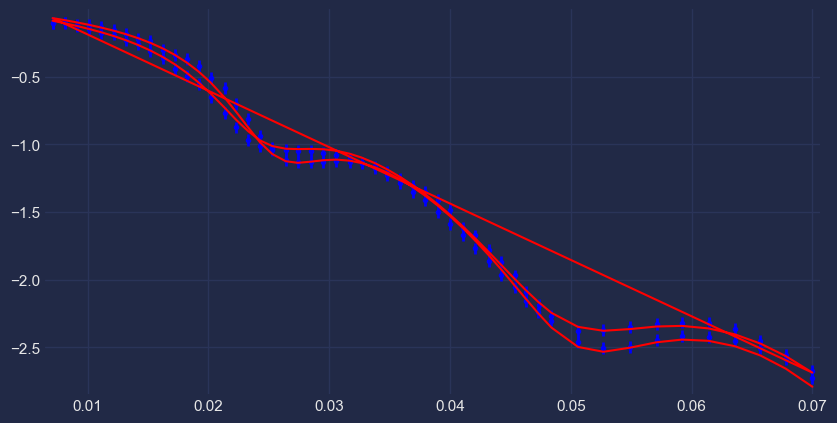

In [60]:
fitter = CurveFitter(obj_275, nwalkers=nwalkers, moves = move)
fitter.initialise("jitter")
chain = fitter.sample(int(nwalkers), random_state=random_state)
lp = fitter.logpost
plt.plot(-lp)

print(obj_275.varying_parameters())
obj_275.plot()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

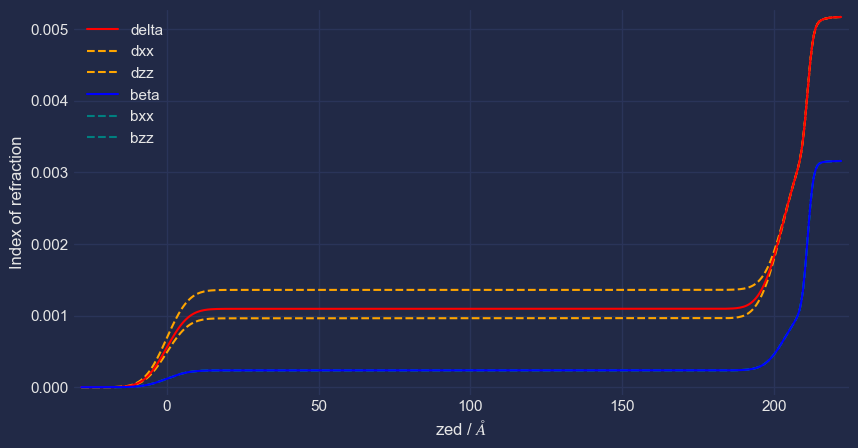

In [61]:
struct_283p7.plot()

In [63]:
import json

# Just build a json able data structure for the slab parameters

fit_res = {
    str(en):{
        "delta": {
            "xx"  : float(znpc_1.sld.xx.value),
            "dxx" : float(znpc_1.sld.xx.stderr),
            "zz"  : float(znpc_1.sld.zz),
            "dzz" : float(znpc_1.sld.zz.stderr),
            "iso" : float(znpc_1.sld.delta.value),
            "diso": float(znpc_1.sld.delta.stderr),
        },
        "beta": {
            "xx"  : float(znpc_1.sld.ixx.value),
            "dxx" : 0,
            "zz"  : float(znpc_1.sld.izz.value),
            "dzz" : 0,
            "iso" : float(znpc_1.sld.beta.value),
            "diso": float(znpc_1.sld.beta.stderr),
        }
    }
}

fit_res_path = db.refl.parent / "res" / "ZnPc"
fit_res_path.mkdir(parents=True, exist_ok=True)

with open(fit_res_path / "fit_res.json", "w") as f:
    json.dump(fit_res, f, indent=4)

## Fit 280 eV Data

## <a id='toc1_2_'></a>[Fit 283.7 eV Data](#toc0_)

### <a id='toc1_2_1_'></a>[Load the 283.7 eV data](#toc0_)

[Text(0.5, 1.0, '$200 \\AA$ ZnPc Mono Layer Reflectivity Data'),
 Text(0, 0.5, '$I_R / I_0$ [a.u.]'),
 None]

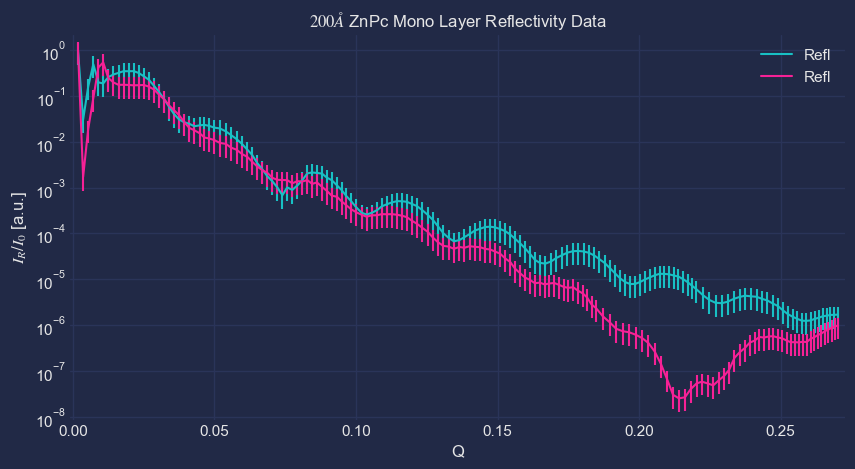

In [47]:
fig, ax = plt.subplots()

znpc_mono_283p7_s = znpc_mono["283.7"]["s"]
znpc_mono_283p7_p = znpc_mono["283.7"]["p"]

# Modify the error to 20 percent
scale = .5
znpc_mono_283p7_s["Err"] = znpc_mono_283p7_s["Refl"]*scale
znpc_mono_283p7_p["Err"] = znpc_mono_283p7_p["Refl"]*scale

znpc_mono_283p7_s.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_p.plot(ax = ax, x = "Q", y = "Refl", yerr = "Err")
ax.set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

#### <a id='toc1_2_1_1_'></a>[Various Masking Attempts](#toc0_)

[Text(0.5, 0, 'Q [$\\AA^{-1}$]'), Text(0, 0.5, '$I_R / I_0$ [a.u.]'), None]

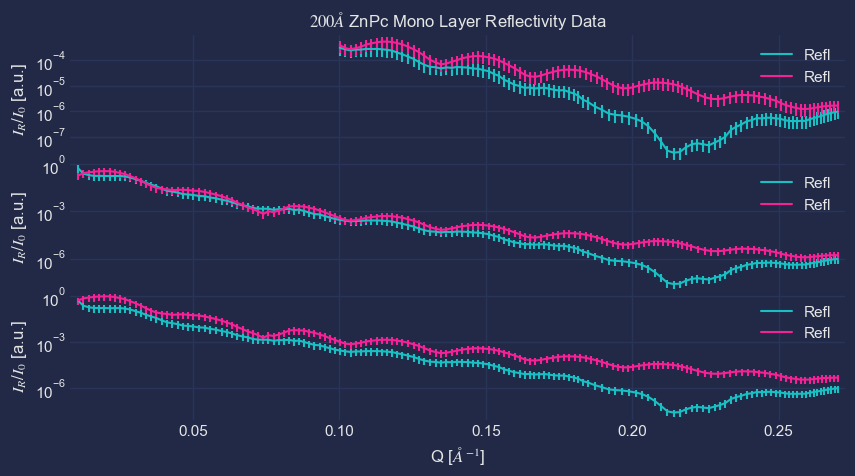

In [53]:
fig, ax = plt.subplots(nrows = 3, sharex=True, gridspec_kw={"hspace":0})
# (Extream Remove Low Q) Masking <.1

znpc_mono_283p7_s_extreme = znpc_mono_283p7_s[znpc_mono_283p7_s["Q"] > .1]
znpc_mono_283p7_p_extreme = znpc_mono_283p7_p[znpc_mono_283p7_p["Q"] > .1]

znpc_mono_283p7_p_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_extreme.plot(ax = ax[0], x = "Q", y = "Refl", yerr = "Err")
ax[0].set(
    title = r"$200 \AA$ ZnPc Mono Layer Reflectivity Data",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

znpc_mono_283p7_extreme = rf.to_refnx_dataset(znpc_mono_283p7_s_extreme, pol = "sp", second_pol=znpc_mono_283p7_p_extreme)

# (Remove Low Q) Masking first 5 points
znpc_mono_283p7_s_lowq = znpc_mono_283p7_s.iloc[5:]
znpc_mono_283p7_p_lowq = znpc_mono_283p7_p.iloc[5:]

znpc_mono_283p7_p_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq.plot(ax = ax[1], x = "Q", y = "Refl", yerr = "Err")
ax[1].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)

znpc_mono_283p7_lowq = rf.to_refnx_dataset(znpc_mono_283p7_s_lowq, pol = "sp", second_pol=znpc_mono_283p7_p_lowq)

# (Remove Low Q + Scale)

znpc_mono_283p7_s_lowq_scale = znpc_mono_283p7_s_lowq.copy()
znpc_mono_283p7_p_lowq_scale = znpc_mono_283p7_p_lowq.copy()
scale = znpc_mono_283p7_p_lowq_scale["Refl"].iloc[0] / znpc_mono_283p7_s_lowq_scale["Refl"].iloc[0]
znpc_mono_283p7_s_lowq_scale["Refl"] *= scale
znpc_mono_283p7_s_lowq_scale["Err"] *= scale

znpc_mono_283p7_lowq_scale = rf.to_refnx_dataset(znpc_mono_283p7_s_lowq_scale, pol = "sp", second_pol=znpc_mono_283p7_p_lowq_scale)

znpc_mono_283p7_p_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
znpc_mono_283p7_s_lowq_scale.plot(ax = ax[2], x = "Q", y = "Refl", yerr = "Err")
ax[2].set(
    xlabel = r"Q [$\AA^{-1}$]",
    ylabel = r"$I_R / I_0$ [a.u.]",
    yscale = "log",
)


### <a id='toc1_2_2_'></a>[Construct the slab structure for the data](#toc0_)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='zed / $\\AA$', ylabel='Index of refraction'>)

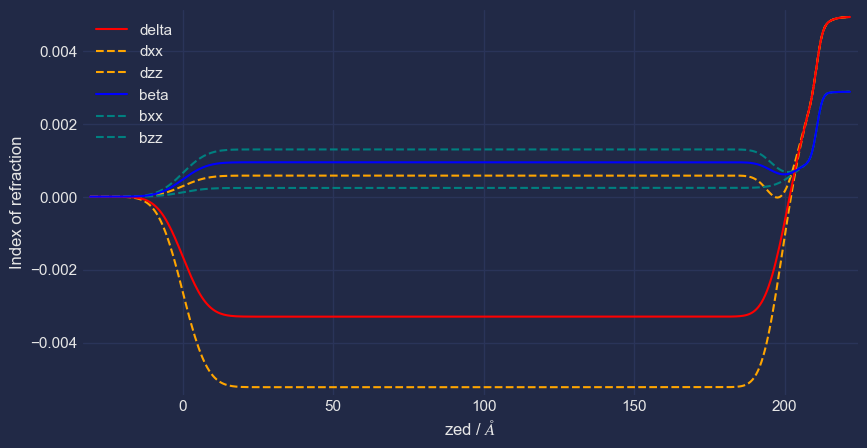

In [58]:
en = 283.7
vac = PXR_MaterialSLD("", 0, en)(0, 0)
si_1 = PXR_MaterialSLD("Si", si.sld.density, en, name="Si")(si_thick,si_rough)
sio2_1 = PXR_MaterialSLD("SiO2", sio2.sld.density, en, name="SiO2")(sio2_thick,sio2_rough)
c_amor_1 = PXR_MaterialSLD("C", c_amor.sld.density, en, name="C_Amorphous")(c_amor_thick, c_amor_rough)

n = np.array([znpc_oc["zz"].n(en), znpc_oc["xx"].n(en)])

biref = znpc_oc["zz"].delta(en) - znpc_oc["xx"].delta(en)
dicrho = znpc_oc["zz"].beta(en) - znpc_oc["xx"].beta(en)

znpc_1 = PXR_SLD(n, symmetry="uni", name = "ZnPc")(znpc_thick, znpc_rough)

struct_283p7 = vac | znpc_1 | c_amor_1 | sio2_1 | si_1
struct_283p7.plot()

### <a id='toc1_2_3_'></a>[Construct the Objective Function](#toc0_)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

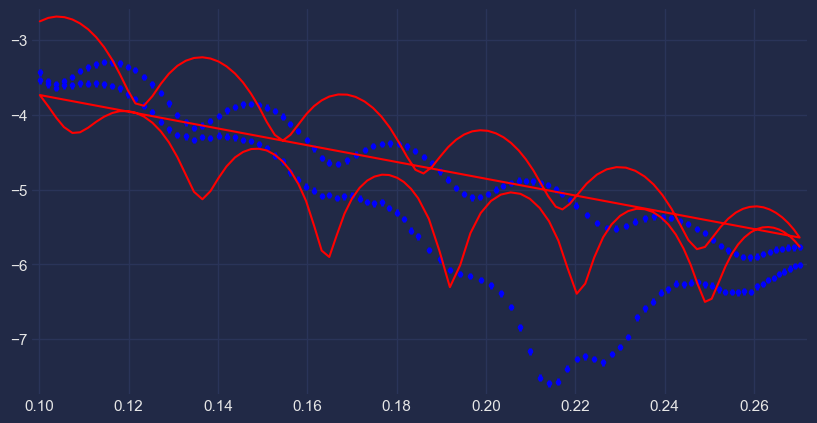

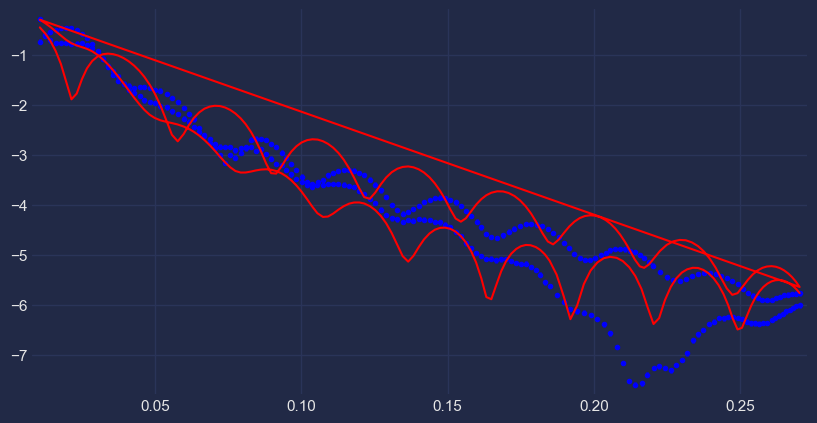

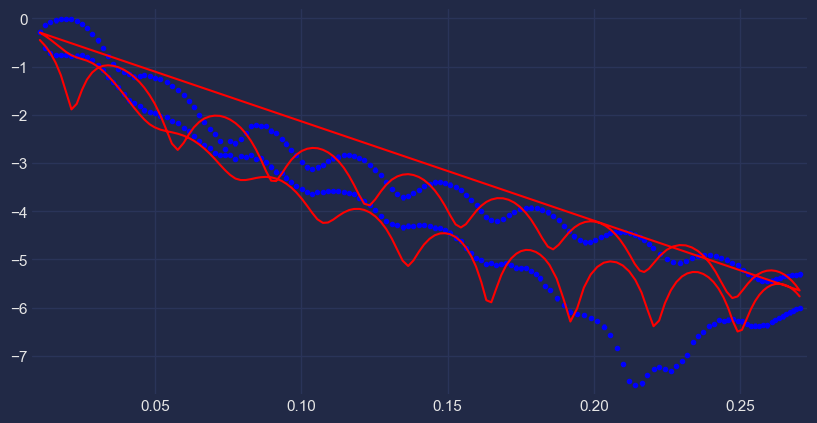

In [59]:
model_283p7 = PXR_ReflectModel(struct_283p7, pol = "sp", energy = en, name = "ZnPc Mono Layer 283p7eV")
model_283p7.scale.setp(vary = True, bounds = (0.6, 1.2))
model_283p7.bkg.setp(vary = True, bounds = (1e-9, 1e-6))

# Low q masking
from pyref.fitting.logp import LogpExtra_rough
obj_283p7_lowq = Objective(model_283p7, znpc_mono_283p7_extreme, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_lowq)
obj_283p7_lowq.logp_extra = logp

obj_283p7_lowq.plot()

# extream q masking
obj_283p7_extreme = Objective(model_283p7, znpc_mono_283p7_lowq, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_extreme)
obj_283p7_extreme.logp_extra = logp

obj_283p7_extreme.plot()

# Low q masking + scale
obj_283p7_lowq_scale = Objective(model_283p7, znpc_mono_283p7_lowq_scale, transform=Transform("logY"))
logp = LogpExtra_rough(obj_283p7_lowq_scale)
obj_283p7_lowq_scale.logp_extra = logp

obj_283p7_lowq_scale.plot()

### <a id='toc1_2_4_'></a>[Fitting the data](#toc0_)

In [60]:
# si slabs
si_1.thick.setp(vary = False)
si_1.rough.setp(vary = False)

# sio2 slabs
sio2_1.thick.setp(vary = None, constraint = sio2_thick) # These are well constrained allready by the Bare si fitting
sio2_1.rough.setp(vary = None, constraint = sio2_rough)
sio2_1.sld.density.setp(vary = None, constraint = sio2_density)

# c_amor slabs
c_amor_1.thick.setp(vary = None, constraint = c_amor_thick) # These are well constrained allready by the Bare si fitting
c_amor_1.rough.setp(vary = None, constraint = c_amor_rough)
c_amor_1.sld.density.setp(vary = None, constraint = c_amor_density)

# znpc slabs
znpc_1.thick.setp(vary = None, constraint = znpc_thick)
znpc_1.rough.setp(vary = None, constraint = znpc_rough)

znpc_1.sld.delta.setp(vary = True, bounds = (-0.01, 0))
znpc_1.sld.beta.setp(vary = True, bounds = (0, .01))

znpc_1.sld.dichroism.setp(vary = None, constraint = dicrho)
znpc_1.sld.birefringence.setp(vary = None, constraint = biref)


znpc_1.sld.xx.setp(vary=None,  constraint=(znpc_1.sld.delta + (1/3)*znpc_1.sld.birefringence))
znpc_1.sld.zz.setp(vary=None,  constraint=(znpc_1.sld.delta - (2/3)*znpc_1.sld.birefringence))
znpc_1.sld.ixx.setp(vary=None, constraint=(znpc_1.sld.beta  + (1/3)*znpc_1.sld.dichroism))
znpc_1.sld.izz.setp(vary=None, constraint=(znpc_1.sld.beta  - (2/3)*znpc_1.sld.dichroism))

100%|██████████| 200/200 [00:17<00:00, 11.22it/s]


(<Figure size 1000x500 with 1 Axes>, <Axes: >)

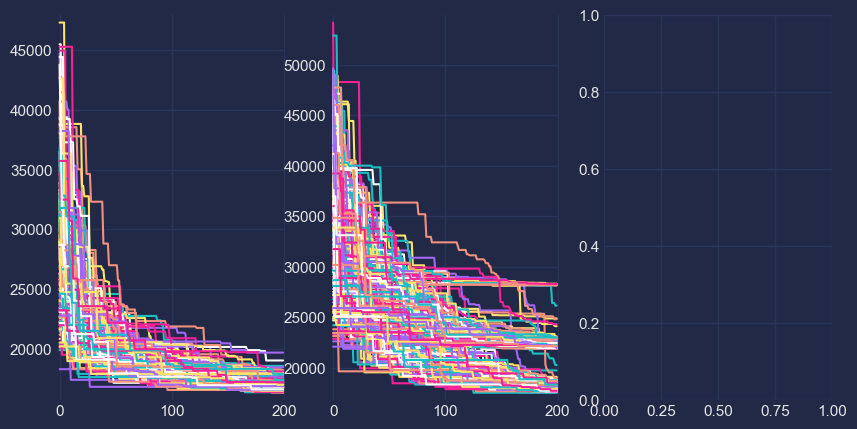

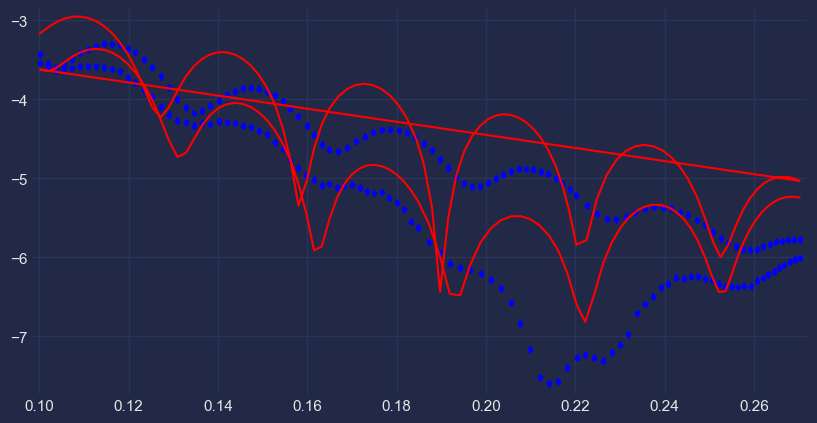

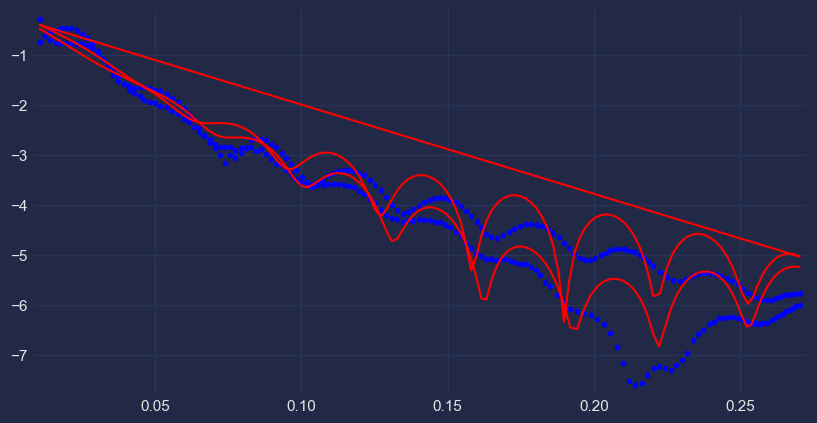

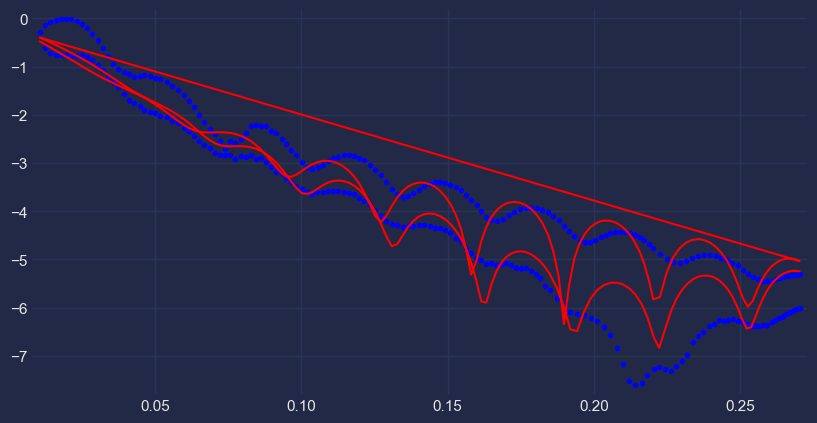

In [61]:
nwalkers = 200

fitter_1_lowq = CurveFitter(obj_283p7_lowq, nwalkers=nwalkers, moves = move)
fitter_1_extreme = CurveFitter(obj_283p7_extreme, nwalkers=nwalkers, moves = move)
fitter_1_lowq_scale = CurveFitter(obj_283p7_lowq_scale, nwalkers=nwalkers, moves = move)

fitter_1_lowq.initialise("prior")
fitter_1_extreme.initialise("prior")
fitter_1_lowq_scale.initialise("prior")

chain_1_lowq = fitter_1_lowq.sample(int(nwalkers), random_state=random_state)
chain_1_extreme = fitter_1_extreme.sample(int(nwalkers), random_state=random_state)
chain_1_lowq_scale = fitter_1_lowq_scale.sample(int(nwalkers), random_state=random_state)

lp_1_lowq = fitter_1_lowq.logpost
lp_1_extreme = fitter_1_extreme.logpost
lp_1_lowq_scale = fitter_1_lowq_scale.logpost

fig, ax = plt.subplots(ncols = 3)
ax[0].plot(-lp_1_lowq)
ax[1].plot(-lp_1_extreme)
ax[1].plot(-lp_1_lowq_scale)

obj_283p7_lowq.plot()
obj_283p7_extreme.plot()
obj_283p7_lowq_scale.plot()